In [1]:
# importing
%pylab inline
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')

import ipy_table

from IPython.display import display, Math, Latex, HTML, clear_output
from scipy import optimize

# set plot text soze
matplotlib.rcParams.update({'font.size': 14})

Populating the interactive namespace from numpy and matplotlib


# 1.Preparation 

## 1.1 Parameters for model 

In [2]:
N_eig = 15

In [3]:
eigenvalues = np.load('lab2_data/new_eigenvalues.npy')
print("Real: %s" % eigenvalues.real)
print("Imag: %s" % eigenvalues.imag)

Real: [-4.0634477  -2.38125981 -2.08185447 -4.16007062 -0.44738645 -1.70874879
 -2.22237478 -0.77799087 -0.38459865 -3.29976385 -2.82983978 -0.40125993
 -3.08194229 -0.49678683 -4.31856531]
Imag: [ 5.44925367  4.57277675  3.33890477  0.59493493  4.32536593  3.17255571
  4.22488651  5.01428523  0.4938021   1.93839564  5.99899502  5.78011929
  1.17344378  0.35221141  4.17774086]


In [4]:
#fc&fs=1
fc = np.ones(N_eig)
fs = np.ones(N_eig)

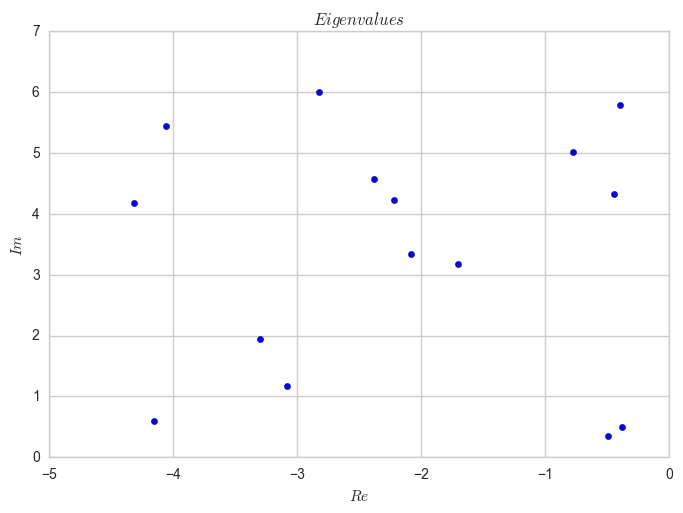

In [5]:
#plot eigenvalues
fig1, axes1 = plt.subplots()

axes1.scatter(eigenvalues.real, eigenvalues.imag)
axes1.set_xlabel('$Re$')
axes1.set_ylabel('$Im$')
_ = axes1.set_title('$Eigenvalues$')

## 1.2 Generate Y

$$y_k=\sum_{j=0}^{k-1} h_{k-j}u_j,$$
$$h_k=\sum_{p=1}^P \left(\rho_p^k (f_q^c\cos\omega_p(k-1)+f_q^s\sin\omega_p(k-1)\right),$$
<center>$\rho_p=\sqrt{\alpha_p^2+\beta_p^2}$,
$\omega_p=arccos\frac{\alpha_p}{\sqrt{\alpha_p^2+\beta_p^2}}$,
$\alpha_p=e^{\lambda_p\Delta}\cos\gamma_p\Delta$,
$\beta_p=e^{\lambda_p\Delta}\sin\gamma_p\Delta$</center>

We set $f_q^c=1$, $f_q^c=1$.

In [6]:
def y_cont(t, eigen, f_c, f_s):
    """continious impulse response"""
    res = 0
    for i in range(N_eig):
        res += (f_c[i]*np.cos(eigen[i].imag*t)+f_s[i]*np.sin(eigen[i].imag*t))*np.exp(eigen[i].real*t)
    return res

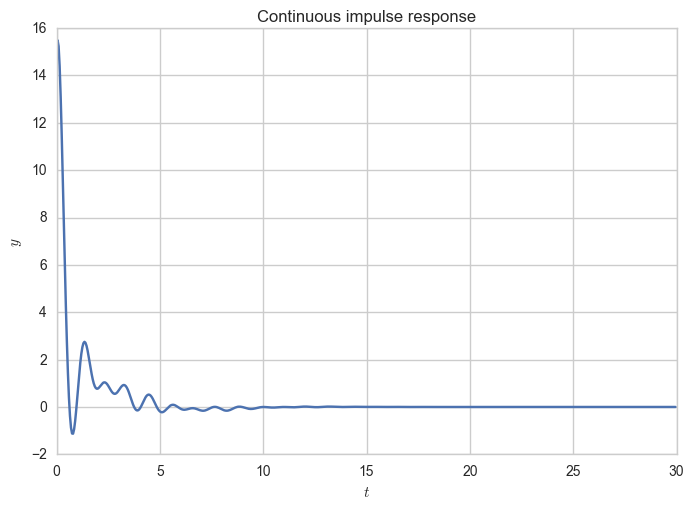

In [7]:
t = np.arange(0, 30, 0.05)
y_c = y_cont(t, eigenvalues, fc, fs)

fig2, axes2 = plt.subplots()

axes2.plot(t, y_c)
axes2.set_xlabel('$t$')
axes2.set_ylabel('$y$')
_ = axes2.set_title('Continuous impulse response')

## 1.3 Generate error

In [8]:
def norm_error(eps, n):
    error = []
    for i in range(n):
        a = np.random.normal(scale=eps/3)
        while abs(a)>eps:
            a = np.random.normal(scale=eps/3)
        error.append(a)
    return np.array(error)

In [9]:
def uniform_error(eps, n):
    return np.random.uniform(-eps, eps, size=n)

In [10]:
def two_peaks_error(eps, n):
    error = []
    for i in range(int(n/2)):
        a = np.random.normal(loc=-0.2, scale=eps/3)
        while abs(a)>eps:
            a = np.random.normal(loc=-0.2, scale=eps/3)
        error.append(a)
        a = np.random.normal(loc=0.2, scale=eps/3)
        while abs(a)>eps:
            a = np.random.normal(loc=0.2, scale=eps/3)
        error.append(a)
    if len(error)<n:
        a = np.random.normal(loc=0.2, scale=eps/3)
        while abs(a)>eps:
            a = np.random.normal(loc=0.2, scale=eps/3)
        error.append(a)
    return np.array(error)

## 1.4 Generate response

<center>$\alpha_p=e^{\lambda_p\Delta}\cos\gamma_p\Delta$</center> 
<center>$\beta_p=e^{\lambda_p\Delta}\sin\gamma_p\Delta$</center>

$$\rho_p=\sqrt{\alpha_p^2+\beta_p^2},\; \omega_p=arccos\frac{\alpha_p}{\sqrt{\alpha_p^2+\beta_p^2}}$$

$$y_k=\sum_{j=0}^{k-1} h_{k-j}u_j,$$
$$h_k=\sum_{p=1}^P \left(\rho_p^k (f_q^c\cos\omega_p(k-1)+f_q^s\sin\omega_p(k-1)\right)$$

In [11]:
def calculate_a_b(delta):
    alpha = [np.exp(el.real*delta)*np.cos(el.imag*delta) for el in eigenvalues]
    beta = [np.exp(el.real*delta)*np.sin(el.imag*delta) for el in eigenvalues]
    return np.array(alpha), np.array(beta)

In [12]:
def calculate_response(delta, N, J, alpha, beta):
    length = 2 * N * J
    rho = np.sqrt(alpha**2+beta**2)
    omega = np.arccos(alpha/rho)
    h = [np.sum(rho**i*(fc*np.cos(omega*i)+fs*np.sin(omega*i))) for i in range(length)]
    u = np.hstack((np.ones(N), np.zeros(N))*J)
    y = np.convolve(h, u)[:length]
    return np.array(y), np.array(u), np.array(h)

In [13]:
def plot_error(error, eps):
    fig4, ax = plt.subplots(figsize=(16, 7))
    
    weights = np.ones_like(error)/(float(len(error)))

    n, *_ = ax.hist(error, 100, range = (-1.0, 1.0), facecolor='blue', weights=weights, alpha=0.3)

    ax.set_xlabel('error')
    ax.set_ylabel('likelihood')
    ax.set_xlim(-1.3*eps, 1.3*eps)
    ax.set_ylim(0, max(n)+0.05)
    ax.set_title('Error plot')

In [14]:
def calculate_parameters(eps, split_depth, T, J, gen_error, if_plot=False):
    """
    Returns alpha, beta, y_real, u, h_real, error, y_noisy.
    """ 
    delta = T / 2**(split_depth + 1)
    N = round(T/delta)
    length = 2 * N * J
    alpha, beta = calculate_a_b(delta)
    y_real, u, h_real = calculate_response(delta, N, J, alpha, beta)

    np.random.seed(0)
    error = gen_error(eps, length)

    y_noisy = y_real + error
    
    if if_plot:
        t = np.linspace(0, T * 2 * J, length)

        fig3, axes3 = plt.subplots(figsize=(16, 7))

        axes3.plot(t, y_real, label = '$y_{noisy}$')
        axes3.plot(t, h_real, label = '$h_{real}$')
        axes3.set_xlabel('$k$')
        axes3.set_ylabel('$y_k$')
        axes3.legend()
        axes3.set_title('Discrete response')
        
        fig4, axes4 = plt.subplots(figsize=(16, 7))

        axes4.plot(t, [y_real[i]/error[i] for i in range(length)])
        axes4.set_xlabel('k')
        axes4.set_ylabel('$y_k/\\varepsilon_k$')
        axes4.set_title('$y/\\varepsilon$')        
        plot_error(error, eps)
        
    return dict(alpha=alpha, beta=beta, y=y_real, signal=u,
                h=h_real, noise=error, y_noisy=y_noisy, delta=delta)

In [15]:
# global variables
Eps = 0.5
T = 20
split_depth = 6
no_stages = 5

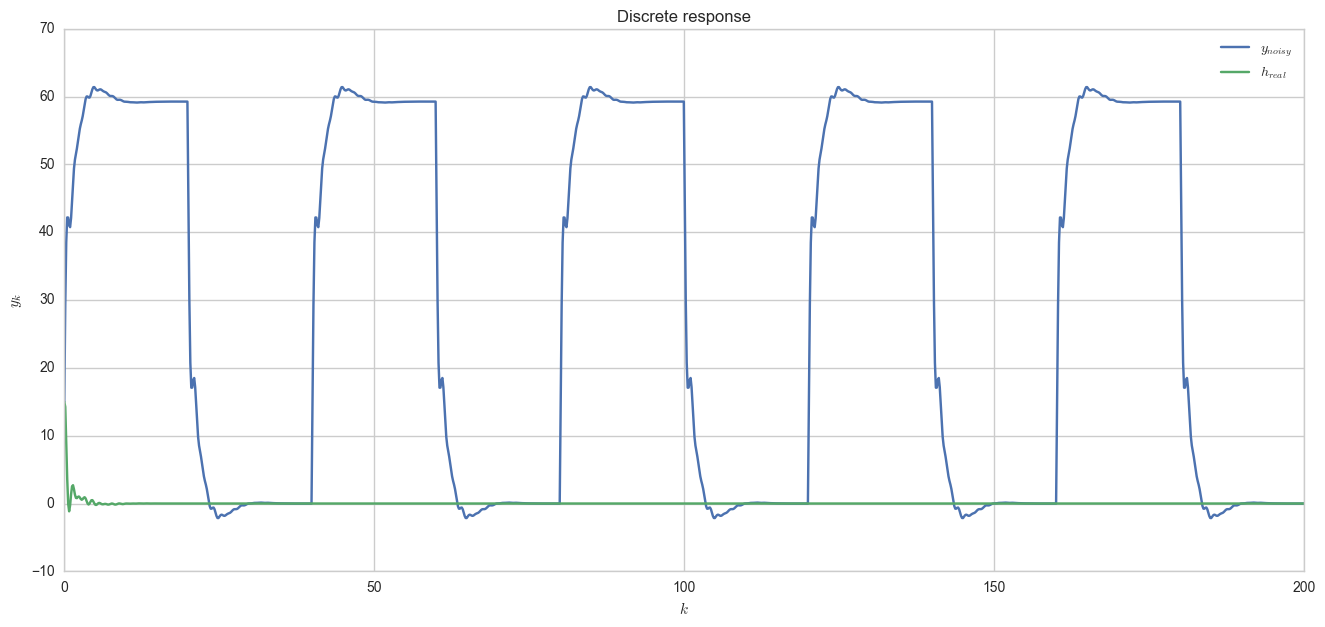

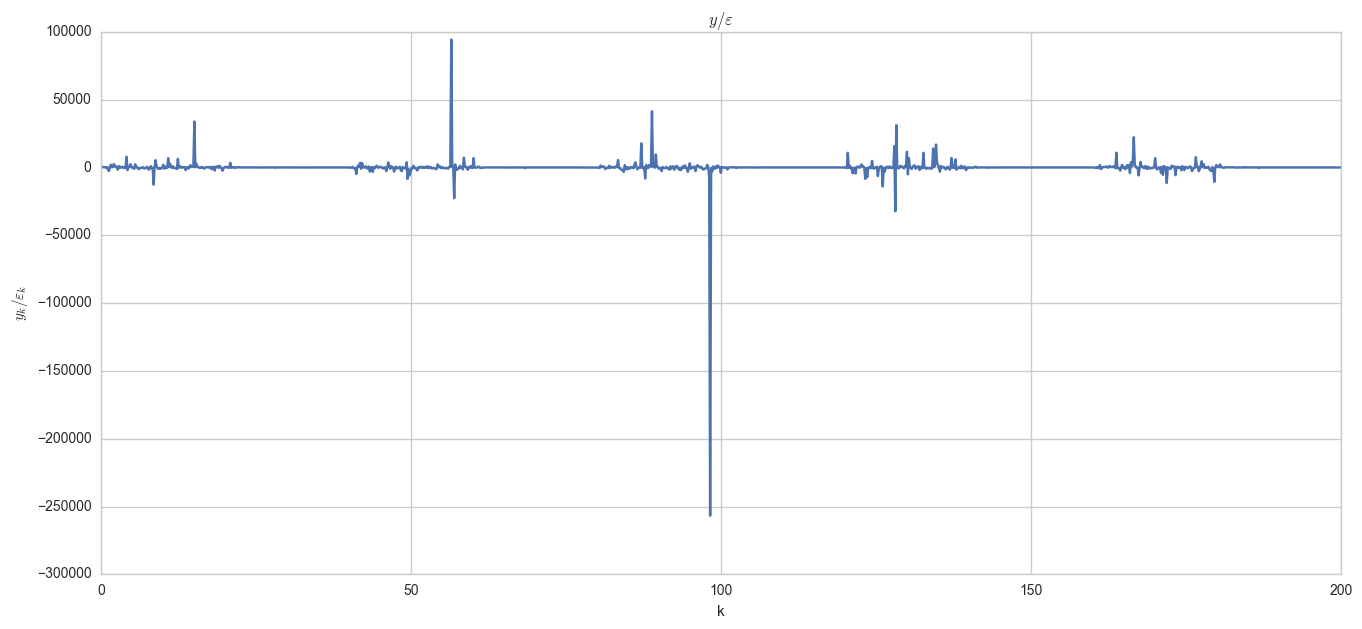

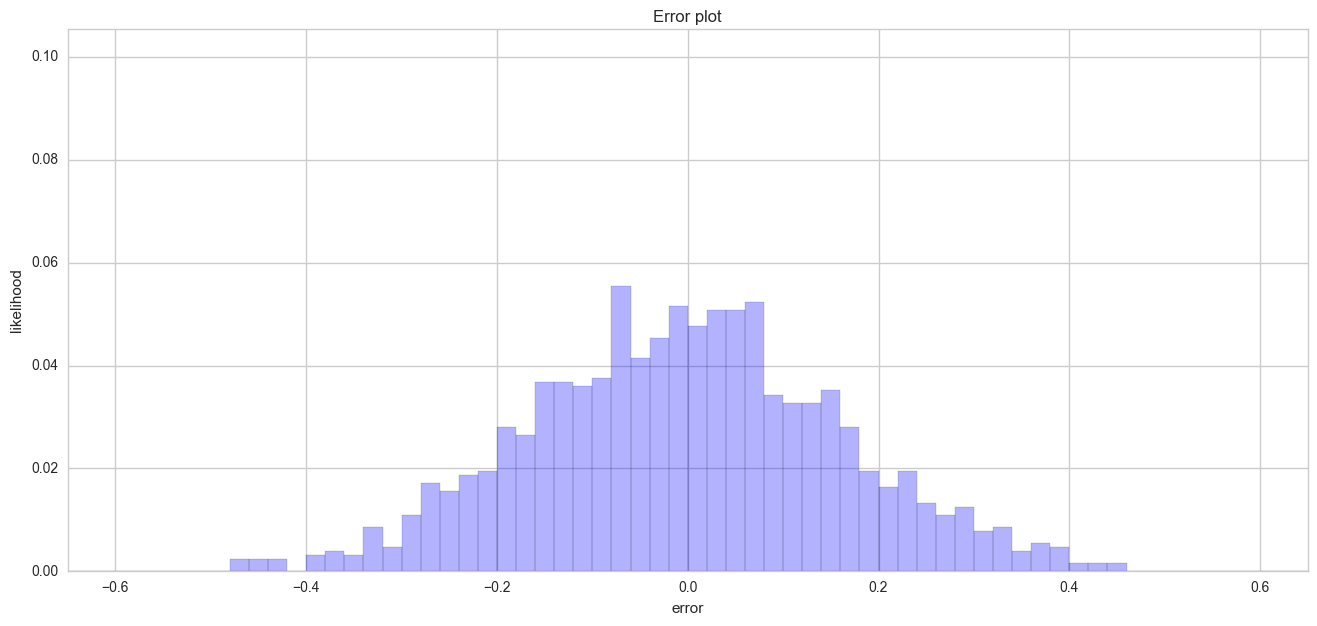

In [16]:
params = calculate_parameters(Eps, split_depth, T, no_stages, norm_error, True)

## 1.6 Performing Tihonov's method

In [17]:
def solve_epoch(y_epoch, detalization, epoch_no, delta, h_prev=None):
    global split_depth
    global print_detailed
    epoch_size = 2 ** (split_depth + 2)
    timegrid = arange(1, epoch_size)
    timegrid_y = timegrid + epoch_no * epoch_size
    shift = split_depth - detalization
    sl = slice(2**shift - 1, None, 2**shift)
    y_s = y_epoch[sl]
    h_low, h_high = -np.inf, np.inf
    # upper triangle
    bound = 2 ** (detalization + 1)
    h = y_s[:bound].copy()
    h[1:] = y_s[1:bound] - y_s[:bound - 1]
    h_low_, h_high_ = h - 2 * Eps, h + 2 * Eps
    h_low_[0] += Eps
    h_high_[0] -= Eps
    h_low, h_high = np.maximum(h_low, h_low_), np.minimum(h_high, h_high_)
    if h_prev:
        h_low_[1::2], h_high_[1::2] = h_prev[0] - h_high_[0::2], h_prev[1] - h_low_[0::2]
        h_low, h_high = np.maximum(h_low, h_low_), np.minimum(h_high, h_high_)
    # lower triangle
    h = y_s[bound - 1:].copy()
    h[:-1] = y_s[bound - 1:2 * bound - 2] - y_s[bound:]
    h_low_, h_high_ = h - 2 * Eps, h + 2 * Eps
    h_low_[-1] += Eps
    h_high_[-1] -= Eps
    h_low, h_high = np.maximum(h_low, h_low_), np.minimum(h_high, h_high_)
    if h_prev:
        h_low_[1::2], h_high_[1::2] = h_prev[0] - h_high_[0::2], h_prev[1] - h_low_[0::2]
        h_low, h_high = np.maximum(h_low, h_low_), np.minimum(h_high, h_high_)
    if print_detailed:
    # plotting stuff
        caption = 'Epoch: %d. Detalization level: %d. Delta: %0.4f.' % (epoch_no + 1, detalization + 1, 2**shift * delta)
        fig, (ax_y, ax_h) = subplots(1, 2, figsize=(12,3))
        # y plot
        ax_y.set_title(caption)
        ax_y.set_xlabel('$k$')
        ax_y.set_ylabel('$y_k$')
        ax_y.plot(timegrid_y, y_epoch, 'r', label='$y$')
        ax_y.plot(timegrid_y[sl],y_epoch[sl], 'b', linestyle='--', label='$y_{selected}$')
        ax_y.legend(loc='upper right')
        # h plot
        ax_h.set_title('$h$')
        ax_h.set_xlabel('$k$')
        ax_h.set_ylabel('$h_k$')
        ax_h.plot(timegrid[sl][:-bound+1], (h_low + h_high) / 2, 'r-')
        ax_h.fill_between(timegrid[sl][:-bound+1], h_high, h_low, color='b', alpha=0.2)
    return h_low, h_high

In [18]:
def solve_detalization(detalization, delta, h_prev=None):
    global no_stages
    global split_depth
    global T
    h_min = []
    h_max = []
    for epoch_no in range(no_stages):
        h_min_max = solve_epoch(y_noisy[epoch_no][:-1], detalization, epoch_no, delta, h_prev)
        h_min.append(h_min_max[0])
        h_max.append(h_min_max[1])
    h_low, h_high = np.amax(h_min, axis=0), np.amin(h_max, axis=0)
    # plotting aggragated h
    shift = 2**(split_depth - detalization)
    real_timegrid = arange(shift, shift*(h_low.shape[0] + 1), shift) * delta
    fig, ax_h = subplots(figsize=(12,3))
    fig.set_size_inches(12, 3)
    ax_h.set_title('$h$ with delta = %0.4f' % (shift * delta))
    ax_h.set_xlabel('$t$')
    ax_h.set_ylabel('$h_k$')
    ax_h.plot(real_timegrid, (h_low + h_high) / 2, 'r-')
    ax_h.fill_between(real_timegrid, h_high, h_low, color='b', alpha=0.2)
    ax_h.set_xlim((0, T))
    return h_low, h_high

In [19]:
def solve_tixonov(delta):
    global split_depth
    h_current = None
    for detal in range(split_depth + 1):
        h_current = solve_detalization(detal, delta)
    return h_current

In [20]:
y_noisy = params['y_noisy']
epoch_size = y_noisy.shape[0] // no_stages
y_noisy = y_noisy.reshape(no_stages, epoch_size) # y_noisy[epoch, index]
print_detailed = False

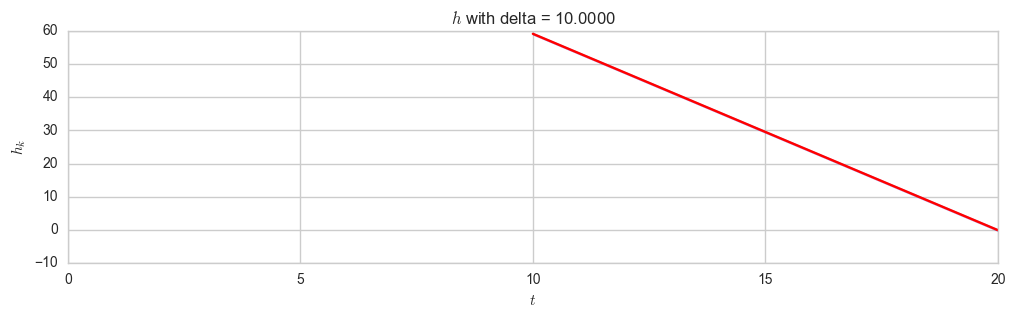

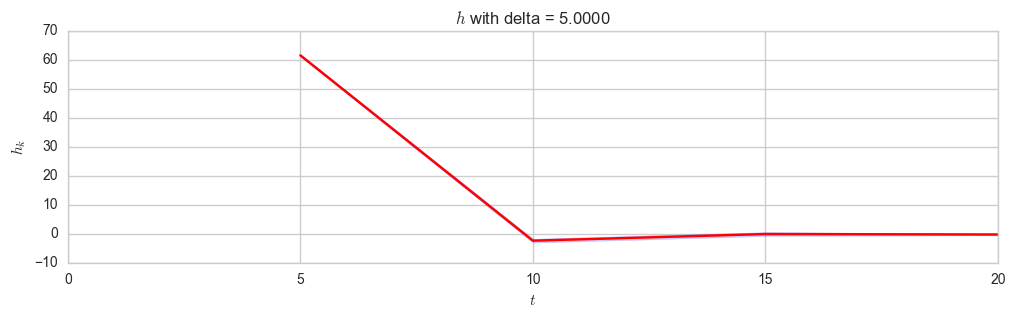

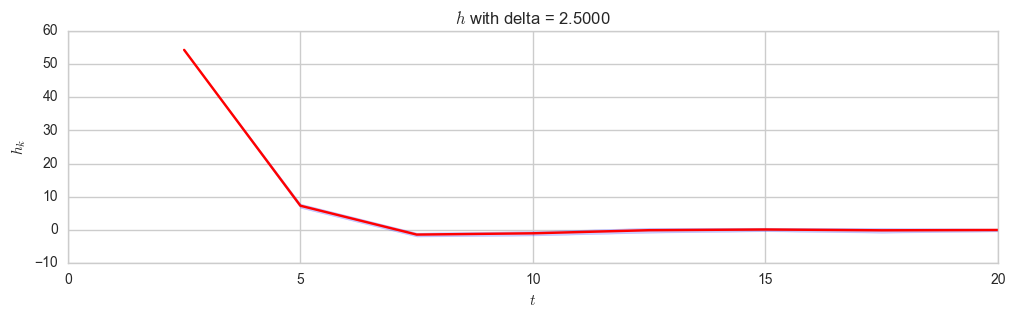

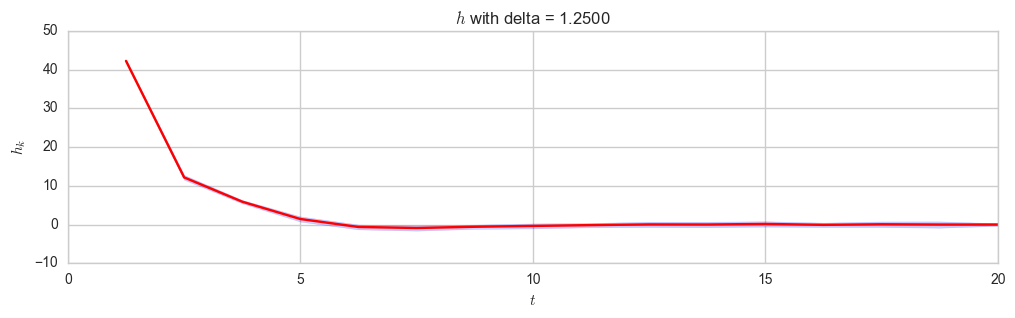

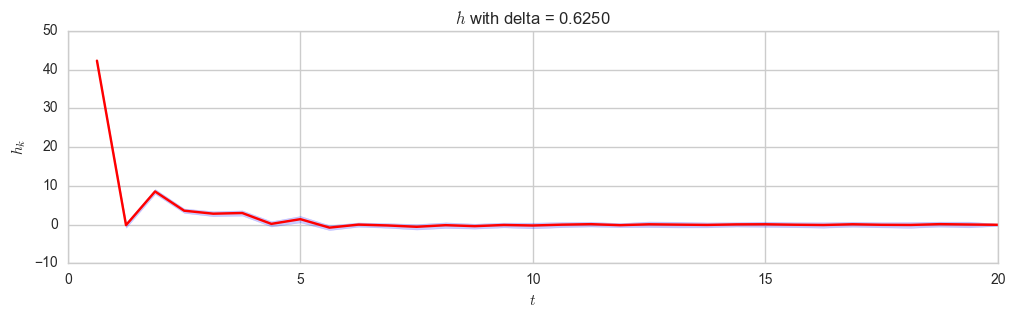

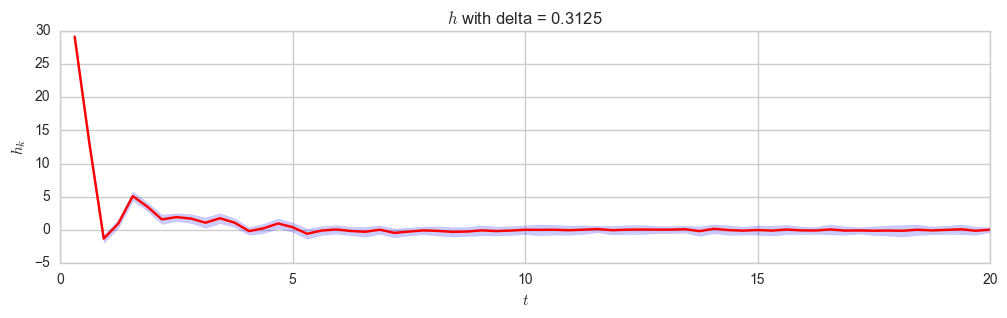

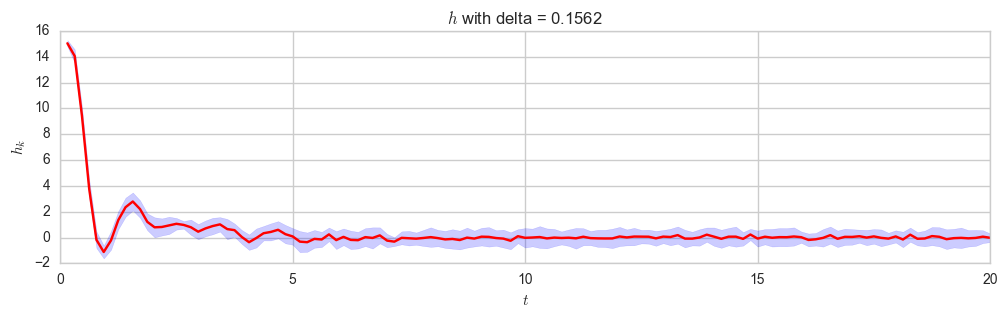

In [21]:
h_low, h_high = solve_tixonov(params['delta'])

In [22]:
h_length =  h_low.shape[0]
timegrid = (arange(h_length) + 1) * params['delta']

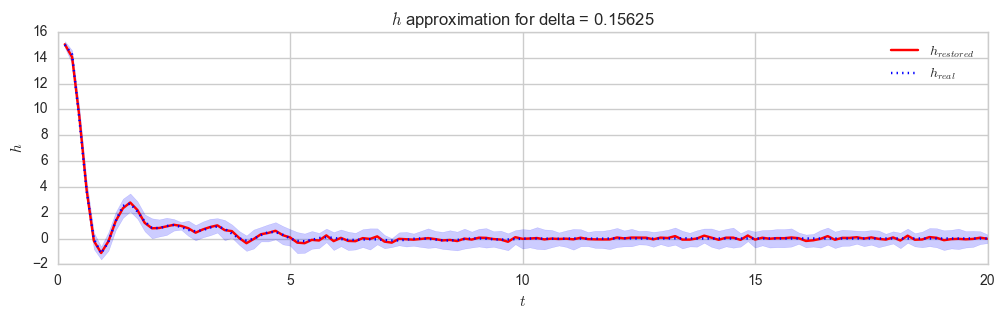

In [23]:
_, ax = subplots(figsize=(12,3))
ax.plot(timegrid, (h_low + h_high) / 2, 'r-', label='$h_{restored}$')
ax.fill_between(timegrid, h_high, h_low, color='b', alpha=0.2)
ax.plot(timegrid, params['h'][:h_length], c='b', ls='dotted', label='$h_{real}$')
ax.legend(loc='upper right')
ax.set_xlabel('$t$')
ax.set_ylabel('$h$')
_ = ax.set_title('$h$ approximation for delta = %0.5f' % (params['delta']))